---
# **CONTEXTO**
---

A pandemia de COVID-19 atingiu o mundo inteiro, sobrecarregando os sistemas de saúde - despreparados para uma demanda tão intensa e prolongada de leitos de UTI, profissionais, equipamentos de proteção individual e de recursos de saúde.

Neste sentido, é inegável a urgência na obtenção e manipulação de dados para melhorar a previsão e assim, conseguir preparar o sistema de saúde, evitando colapsos.

O Brasil registrou o primeiro caso de COVID-19 em 26 de fevereiro de 2020 e atingiu a transmissão comunitária em 20 de março do mesmo ano.

---
# **OBJETIVO**
---

O objetivo deste projeto é prever quais pacientes precisarão ser admitidos na unidade de terapia intensiva e assim, definir qual a necessidade de leitos de UTI no Hospital Sírio Libanês a partir dos dados clínicos individuais disponíveis.

Quando a quantidade de leitos necessários em um determinado hospital é definida, é possível evitar rupturas, visto que, caso outra pessoa procure ajuda e, eventualmente, precise de cuidados intensivos, o modelo preditivo conseguirá detectar essa necessidade e, dessa forma, a remoção e transferência desse paciente pode ser organizada antecipadamente.

# **IMPORTAÇÃO DAS BIBLIOTECAS**

In [ ]:
!pip install pyjanitor

     |████████████████████████████████| 102kB 4.5MB/s 


In [ ]:
#Importando as bibliotecas
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import matplotlib.ticker   as ticker
import seaborn             as sns
import janitor             as jn

from pandas                    import read_excel
from random                    import randint
from sklearn.model_selection   import train_test_split, StratifiedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble          import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.svm               import SVC
from sklearn.tree              import DecisionTreeClassifier
from sklearn.naive_bayes       import GaussianNB
from sklearn.dummy             import DummyClassifier
from sklearn.metrics           import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score 
from sklearn.metrics           import classification_report, recall_score, precision_score, f1_score
from sklearn.metrics           import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
np.random.seed(433011) 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale=1.1)

# **DEFINIÇÃO DAS FUNÇÕES**

In [ ]:
def preenche_tabela(dados):

  '''
  Esta função separa o dataset em "features_continuas", "features_categoricas" e "saida".
  Agrupa a parte do dataset que contém apenas variáveis contínuas com base na coluna "patient_visit_identifier".
  Preenche os valores faltantes nessas variáveis usando as funções "bfill" e "ffill".
  Concatena todas as partes e retorna o dataset final.

  Parâmetros:
    dados: dataset com os dados a serem utilizados
  
  Retorna:
    dados_finais: dataset com os dados devidamente agrupados e preenchidos
  '''
  
  features_continuas_colunas = dados.iloc[:, 13:-2].columns
  features_continuas = dados.groupby("patient_visit_identifier", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
  features_categoricas = dados.iloc[:, :13]
  saida = dados.iloc[:, -2:]
  dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
  dados_finais.columns = dados.columns

  return dados_finais

In [ ]:
def prepara_janela(linhas):
  '''
  Esta função aplica o valor 1 na coluna "icu" se para alguma das janelas de tempo do paciente, "icu" é igual a 1.
  Esse valor é aplicado na primeira janela de tempo.

  Parâmetro: 
    linhas: linhas do dataset
  
  Retorna:
    linhas correspondentes a primeira janela de tempo de cada paciente

  '''
  
  if(np.any(linhas["icu"])):
      linhas.loc[linhas["window"]=="0-2", "icu"] = 1

  return linhas.loc[linhas["window"] == "0-2"]

In [ ]:
def getDuplicateColumns(df):
  '''
  Get a list of duplicate columns.
  It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.

    param df: Dataframe object
    
    return: List of columns whose contents are duplicates.
  '''

  duplicateColumnNames = set()
  # Iterate over all the columns in dataframe
  for x in range(df.shape[1]):
      # Select column at xth index.
      col = df.iloc[:, x]
      # Iterate over all the columns in DataFrame from (x+1)th index till end
      for y in range(x + 1, df.shape[1]):
          # Select column at yth index.
          otherCol = df.iloc[:, y]
          # Check if two columns at x 7 y index are equal
          if col.equals(otherCol):
              duplicateColumnNames.add(df.columns.values[y])
  return list(duplicateColumnNames)

  #Fonte: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/#:~:text=Find%20duplicate%20columns%20in%20a%20DataFrame,stored%20in%20duplicate%20column%20list.

In [ ]:
def anotacao(grafico):
  '''
  Esta função adiciona um texto no topo e no centro de cada barra do barplot com o valor correspondente ao eixo y.

  Parâmetros: 
    ax: variável correspondente aos eixos do gráfico
  '''

  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

In [ ]:
def normalize_data(column):
  
  return (column - np.min(column)) / (np.max(column) - np.min(column))

#Fonte: https://stackoverflow.com/questions/18380419/normalization-to-bring-in-the-range-of-0-1

In [ ]:
def avalia_correlacao(dados, limite):
  '''
  Esta função calcula a correlação de Pearson de pares de colunas e seleciona aquelas que tem correlação maior que o limite.

  Parâmetros:
    dados: dataset a ser utilizado
    limite: limite de correlação a partir do qual as colunas serão considerandas com alta correlação entre si
  
  Retorna: 
    coll: colunas com alta correlação entre si
  '''    

  corr = dados.iloc[:, 12:-1].corr()
  mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
  corr_no_diag = corr.where(mask)
  coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limite)]
  
  return coll

In [ ]:
def plota_correlacao(dados):  
  '''
  Esta função plota um heatmap mostrando a correção entre as colunas do dataset.

  Parâmetros:
    dados: dataset a ser utilizado
  '''  
  
  corr = dados.iloc[:, 12:-1].corr()
  mask = np.triu(np.ones(corr.shape), k=1).astype(bool)

  plt.figure(figsize=(18,12))

  ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=False, cmap=sns.color_palette("blend:white,mediumblue", as_cmap=True), fmt=".2f", mask=mask)
  plt.title("Correlação entre variáveis", fontsize=16)
  
  plt.show()

  return ax

In [ ]:
def imprime_shape(dados):
  '''
  Esta função imprime o número de linhas e colunas do dataset.

  Parâmetro:
    dados: dataset a ser utilizado
  '''
    
  return print(f"O dataset agora possui {dados.shape[0]} registros e {dados.shape[1]} colunas.")

In [ ]:
def makebio_df(df: pd.DataFrame):
  '''
  Esta função foi criada pelo time do Hospital Sírio Libanês, cria os atributos "bloodpressure_arterial_mean", "neutrophiles/linfocitos" e 
  "gaso".
  Retorna as variáveis criadas e aquelas do dataset original consideradas relevantes do ponto de vista biológico.

  Parâmetro:
    df: dataset a ser utilizado

  Retorna:
    dataset com as variáveis criadas e aquelas do dataset original consideradas relevantes do ponto de vista biológico
  '''

  df["bloodpressure_arterial_mean"] = (df['bloodpressure_sistolic_mean'] + 2*df['bloodpressure_diastolic_mean'])/3

  df["neutrophiles/linfocitos"] = df['neutrophiles_mean']/df['linfocitos_mean']

  df["gaso"] = df.groupby(df.index).p02_arterial_mean.apply(lambda x: x.fillna(method='ffill'))
  df["gaso"] = (~df["gaso"].isna()).astype(int)

  return df[["age_above65", 
              "gender", 
              "bloodpressure_arterial_mean", 
              "respiratory_rate_max", 
              "htn", 
              'disease_grouping_1',
              'disease_grouping_2',
              'disease_grouping_3',
              'disease_grouping_4',
              'disease_grouping_5',
              'disease_grouping_6',
              "gaso",
              "oxygen_saturation_min",
              "heart_rate_max",
              "pcr_mean",
              "creatinin_mean",
              "icu"]]

In [ ]:
def adiciona_atributos(dados_extra, dados_iniciais): 
  '''
  Esta função recebe dois datasets, faz a comparação entre eles e adiciona no segundo as colunas que só existem no primeiro.

  Parâmetros: 
    dados_extra: dataset a ser comparado
    dados_iniciais: dataset em que serão adicionadas as colunas

  Retorna:
    dados_completos: dataset com todas as colunas de interesse
  ''' 
  
  colunas_adicionar = []

  for coluna in dados_extra.columns:
    if not coluna in dados_iniciais.columns:
      colunas_adicionar.append(coluna)

  dados_completos = dados_iniciais.join(dados_extra[colunas_adicionar])

  return dados_completos

In [ ]:
def cria_modelos(): 
  '''
  Esta função cria uma lista com os modelos de classificação que serão avaliados. 

  Retorna:
    modelos: lista com os modelos de interesse
  '''

  modelos = []

  modelos.append(("Dummy Classifier", DummyClassifier()))
  modelos.append(("K-Nearest Neighbors Classifier", KNeighborsClassifier())) 
  modelos.append(("Support Vector Classifier", SVC())) 
  modelos.append(("Logistic Regression", LogisticRegression(max_iter=10000))) 
  modelos.append(("Decision Tree Classifier", DecisionTreeClassifier())) 
  modelos.append(("Naive Bayes", GaussianNB())) 
  modelos.append(("Random Forest Classifier", RandomForestClassifier(n_estimators=100))) 
  modelos.append(("Gradient Boosting Classifier", GradientBoostingClassifier(n_estimators=100)))

  return modelos

In [ ]:
def separa_xy(dados):
  '''
  Esta função separa as variáveis de entrada (x) e a variável alvo (y).

  Parâmetros:
    dados: dataset a ser separado
  
  Retorna: 
    x: dataset com as variáveis de entrada
    y: variável alvo
  '''

  np.random.seed(433011)
  x_columns = dados.columns
  y = dados["icu"]
  x = dados[x_columns].drop(["icu"], axis=1)

  return x, y

In [ ]:
def separa_train_test(dados):
  '''
  Esta função separa o dataset em treino e de teste estratificando por x e com random_state=433011.

  Parâmetros:
    dados: dataset a ser separado
  
  Retorna:
    x_train, x_test, y_train, y_test: variáveis x e y de treino e de teste
  '''

  x, y = separa_xy(dados)
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=433011, test_size=0.3)

  return x_train, x_test, y_train, y_test

In [ ]:
def calcula_score_treino_teste(dados):
  '''
  Esta função separa o dataset em treino e de teste, treina e testa os modelos de classificação da lista criada pela função 
  "cria_modelos".
  O desempenho de cada modelo é avaliado segundo auc (area under the receiver operating characteristic curve) usando a função 
  roc_auc_score.

  Parâmetros:
    dados: dataset a ser utilizado
  
  Returna:
    score_treino_teste: DataFrame contendo os modelos e os respectivos valores de auc
  '''
  
  modelos = cria_modelos()
  x_train, x_test, y_train, y_test = separa_train_test(dados)

  nomes = []
  roc_auc = []

  for nome, modelo in modelos:
  
      modelo.fit(x_train, y_train)
      y_pred = modelo.predict(x_test)
      
      roc_auc.append(roc_auc_score(y_test, y_pred))
      nomes.append(nome)

  score_treino_teste = pd.DataFrame({"Modelo": nomes, "ROC-AUC": roc_auc})

  return score_treino_teste

In [ ]:
def calcula_score_cross_val(dados):
  '''
  Esta função separa as variáveis de entrada e a variável alvo e avalia os modelos de classificação da lista criada pela função 
  "cria_modelos".
  O desempenho de cada modelo é avaliado segundo auc (area under the receiver operating characteristic curve) usando a validação cruzada 
  "StratifiedKFold".

  Parâmetros:
    dados: dataset a ser utilizado
  
  Returna:
    score_cross_val: DataFrame contendo os modelos e os respectivos valores de auc
  '''
  
  np.random.seed(433011)
  modelos = cria_modelos()
  x, y = separa_xy(dados)
  cv = StratifiedKFold(10, random_state=433011, shuffle=True)
  
  nomes = []
  scores = []

  for nome, modelo in modelos:
      
      score = cross_val_score(modelo, x, y, cv=cv, scoring="roc_auc").mean()
      nomes.append(nome)
      scores.append(score)

  score_cross_val = pd.DataFrame({"Modelo": nomes, "ROC-AUC": scores})

  return score_cross_val

In [ ]:
def avalia_atributos(dados, colunas, modelo):

  dados = dados[colunas]

  x_train, x_test, y_train, y_test = separa_train_test(dados)

  modelo.fit(x_train, y_train)
  y_pred = modelo.predict(x_test)
  y_prob = modelo.predict_proba(x_test)[:,1]

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  acuracia = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precisao = precision_score(y_test, y_pred)
  f_score = f1_score(y_test, y_pred)
  especificidade = (tn/(tn+fp))
  eficiencia = ((recall+especificidade)/2)
  roc_auc = roc_auc_score(y_test, y_prob)

  scores = {"Acurácia": [acuracia],
            "Recall": [recall],
            "Precisão": [precisao],
            "F1-Score": [f_score],
            "Especificidade": [especificidade],
            "Eficiência": [eficiencia],
            "ROC-AUC": [roc_auc]}
  
  plot_confusion_matrix(estimator=modelo, X=x_test, y_true=y_test, cmap="Blues")

  return (pd.DataFrame(scores))

In [ ]:
def plota_doencas(i):
  '''
  Esta função foi criada para simplificar a visualização da Análise Exploratória dos Dados.
  Plota as doenças dos pacientes que não foram para a UTI se i=0 e dos pacientes que foram para a UTI se i=1.

  Parâmetros:
    i: 0 ou 1 indicando a situação dos pacientes 
  '''

  fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)

  if i == 0:
    fig.suptitle("Doenças pré-existentes dos pacientes que NÃO FORAM para a UTI", y=0.91, fontsize=16)
  elif i == 1:
    fig.suptitle("Doenças pré-existentes dos pacientes que FORAM para a UTI", y=0.91, fontsize=16)

  ax = sns.countplot(ax=axes[0, 0], data=dados_eda[dados_eda["icu"] == i], x="disease_grouping_1", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax.set_xlabel("Disease Grouping 1")
  ax.set_ylabel("Contagem")
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

  ax = sns.countplot(ax=axes[0, 1], data=dados_eda[dados_eda["icu"] == i], x="disease_grouping_2", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax.set_xlabel("Disease Grouping 2")
  ax.set_ylabel("Contagem")
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

  ax = sns.countplot(ax=axes[0, 2], data=dados_eda[dados_eda["icu"] == i], x="disease_grouping_3", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax.set_xlabel("Disease Grouping 3")
  ax.set_ylabel("Contagem")
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

  ax = sns.countplot(ax=axes[1, 0], data=dados_eda[dados_eda["icu"] == i], x="disease_grouping_4", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax.set_xlabel("Disease Grouping 4")
  ax.set_ylabel("Contagem")
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

  ax = sns.countplot(ax=axes[1, 1], data=dados_eda[dados_eda["icu"] == i], x="disease_grouping_5", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax.set_xlabel("Disease Grouping 5")
  ax.set_ylabel("Contagem")
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

  ax = sns.countplot(ax=axes[1, 2], data=dados_eda[dados_eda["icu"] == i], x="disease_grouping_6", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax.set_xlabel("Disease Grouping 6")
  ax.set_ylabel("Contagem")
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

  ax = sns.countplot(ax=axes[2, 0], data=dados_eda[dados_eda["icu"] == i], x="htn", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax.set_xlabel("HTN")
  ax.set_ylabel("Contagem")
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

  ax = sns.countplot(ax=axes[2, 1], data=dados_eda[dados_eda["icu"] == i], x="immunocompromised", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax.set_xlabel("Immunocompromised")
  ax.set_ylabel("Contagem")
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

  ax = sns.countplot(ax=axes[2, 2], data=dados_eda[dados_eda["icu"] == i], x="other", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax.set_xlabel("Other")
  ax.set_ylabel("Contagem")
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

  ax.set_xticklabels([0, 1])
  ax.set_ylim(0, 225)

  plt.show()

In [ ]:
def plota_exame_sangue():
  '''
  Esta função foi criada para simplificar a visualização da Análise Exploratória dos Dados.
  Plota os resultados dos exames de sangue dos pacientes que foram ou não para a UTI.

  Parâmetros:
    i: 0 ou 1 indicando a situação dos pacientes 
  '''  

  fig, axes = plt.subplots(9, 4, figsize=(18, 24), sharex=True, sharey=True)

  fig.suptitle("Resultados dos exames de sangue dos pacientes que foram ou não para a UTI", y=0.895, fontsize=16)
      
  ax = sns.violinplot(ax=axes[0, 0], x="icu", y="albumin_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[0, 1], x="icu", y="be_arterial_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[0, 2], x="icu", y="be_venous_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[0, 3], x="icu", y="bic_arterial_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))    

  ax = sns.violinplot(ax=axes[1, 0], x="icu", y="bic_venous_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[1, 1], x="icu", y="billirubin_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))    
  ax = sns.violinplot(ax=axes[1, 2], x="icu", y="blast_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[1, 3], x="icu", y="calcium_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))

  ax = sns.violinplot(ax=axes[2, 0], x="icu", y="creatinin_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))    
  ax = sns.violinplot(ax=axes[2, 1], x="icu", y="ffa_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[2, 2], x="icu", y="ggt_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[2, 3], x="icu", y="glucose_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))

  ax = sns.violinplot(ax=axes[3, 0], x="icu", y="hematocrite_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[3, 1], x="icu", y="hemoglobin_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))    
  ax = sns.violinplot(ax=axes[3, 2], x="icu", y="inr_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))    
  ax = sns.violinplot(ax=axes[3, 3], x="icu", y="lactate_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))

  ax = sns.violinplot(ax=axes[4, 0], x="icu", y="leukocytes_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[4, 1], x="icu", y="linfocitos_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[4, 2], x="icu", y="neutrophiles_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[4, 3], x="icu", y="p02_arterial_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))

  ax = sns.violinplot(ax=axes[5, 0], x="icu", y="p02_venous_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[5, 1], x="icu", y="pc02_arterial_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[5, 2], x="icu", y="pc02_venous_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[5, 3], x="icu", y="pcr_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))  

  ax = sns.violinplot(ax=axes[6, 0], x="icu", y="ph_arterial_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[6, 1], x="icu", y="ph_venous_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[6, 2], x="icu", y="platelets_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))    
  ax = sns.violinplot(ax=axes[6, 3], x="icu", y="potassium_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))

  ax = sns.violinplot(ax=axes[7, 0], x="icu", y="sat02_arterial_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[7, 1], x="icu", y="sat02_venous_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))    
  ax = sns.violinplot(ax=axes[7, 2], x="icu", y="sodium_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))    
  ax = sns.violinplot(ax=axes[7, 3], x="icu", y="tgo_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))

  ax = sns.violinplot(ax=axes[8, 0], x="icu", y="tgp_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[8, 1], x="icu", y="ttpa_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))    
  ax = sns.violinplot(ax=axes[8, 2], x="icu", y="urea_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
  ax = sns.violinplot(ax=axes[8, 3], x="icu", y="dimer_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))

  plt.show()

# **IMPORTAÇÃO DOS DADOS**

A base de dados disponibilizada no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) contém dados anônimos do Hospital Sírio-Libanês de São Paulo e de Brasília. 

Todos os dados foram anonimizados de acordo com as melhores práticas e recomendações internacionais.

Os dados foram limpos e escalados por coluna de acordo com *MinMaxScaler* de modo a estarem entre -1 e 1.

In [ ]:
#Lendo a base de dados
url = "https://github.com/claricefiorese/bootcamp_alura_projetos/blob/main/projeto_final/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true"

dados_raw = pd.read_excel(url)

Ao usar o Pandas, ter nomes de colunas apropriadas para Python torna possível o acesso aos atributos. A função *clean_names* do *pyjanitor* devolverá um DataFrame com as colunas em letras minúsculas e os espaços substituídos por underscores.

In [ ]:
dados_raw = jn.clean_names(dados_raw)

# **ANÁLISE EXPLORATÓRIA DOS DADOS**

A Análise Exploratória de Dados consiste em analisar o dataset e extrair informações úteis dos dados por meio de técnicas de visualização.

Esta etapa é necessária para entender a natureza dos dados, obter algum entendimento dos recursos potenciais e formular hipóteses acerca das informações disponíveis.

### **VARIÁVEL ALVO (TARGET)**

A variável *icu* será considerada a variável alvo.

### **CONCEITO DE JANELA (WINDOW)**

O time do Hospital Sírio Libanês teve o cuidado de incluir cenários reais das janelas de eventos e dados disponíveis.
Os dados foram coletados e agrupados:

<img src="https://github.com/claricefiorese/bootcamp_alura_projetos/blob/main/projeto_final/8.png?raw=true" width="365" height="170"/>

Os dados não devem ser usados quando a variável alvo estiver presente, pois a ordem dos eventos é desconhecida (talvez o evento alvo tenha acontecido antes dos resultados serem obtidos). Esses dados foram mantidos para que seja possível aumentar o dataset com outras informações posteriormente.


<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1591620%2Fb1bc424df771a4d2d3b3088606d083e6%2FTimeline%20Example%20Best.png?generation=1594740856017996&alt=media""/>
<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1591620%2F77ca2b4635bc4dd7800e1c777fed9de1%2FTimeline%20Example%20No.png?generation=1594740873237462&alt=media""/>



## **DADOS DISPONÍVEIS**

<img src="https://raw.githubusercontent.com/claricefiorese/bootcamp_alura_projetos/main/projeto_final/9.png" width="437" height="146"/>

No total, existem 54 variáveis expandidas em média, media, máximo, mínimo, *diff* e *relative diff* quando pertinente.

- *diff = max - min*
- *relative diff = diff/mediana*

In [ ]:
#Exibindo os atributos
for coluna in dados_raw.columns:
    print(coluna)

patient_visit_identifier
age_above65
age_percentil
gender
disease_grouping_1
disease_grouping_2
disease_grouping_3
disease_grouping_4
disease_grouping_5
disease_grouping_6
htn
immunocompromised
other
albumin_median
albumin_mean
albumin_min
albumin_max
albumin_diff
be_arterial_median
be_arterial_mean
be_arterial_min
be_arterial_max
be_arterial_diff
be_venous_median
be_venous_mean
be_venous_min
be_venous_max
be_venous_diff
bic_arterial_median
bic_arterial_mean
bic_arterial_min
bic_arterial_max
bic_arterial_diff
bic_venous_median
bic_venous_mean
bic_venous_min
bic_venous_max
bic_venous_diff
billirubin_median
billirubin_mean
billirubin_min
billirubin_max
billirubin_diff
blast_median
blast_mean
blast_min
blast_max
blast_diff
calcium_median
calcium_mean
calcium_min
calcium_max
calcium_diff
creatinin_median
creatinin_mean
creatinin_min
creatinin_max
creatinin_diff
ffa_median
ffa_mean
ffa_min
ffa_max
ffa_diff
ggt_median
ggt_mean
ggt_min
ggt_max
ggt_diff
glucose_median
glucose_mean
glucose_min


In [ ]:
#Exibindo as 5 primeiras linhas
dados_raw.head()

,patient_visit_identifier,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,albumin_median,albumin_mean,albumin_min,albumin_max,albumin_diff,be_arterial_median,be_arterial_mean,be_arterial_min,be_arterial_max,be_arterial_diff,be_venous_median,be_venous_mean,be_venous_min,be_venous_max,be_venous_diff,bic_arterial_median,bic_arterial_mean,bic_arterial_min,bic_arterial_max,bic_arterial_diff,bic_venous_median,bic_venous_mean,bic_venous_min,bic_venous_max,bic_venous_diff,billirubin_median,billirubin_mean,...,dimer_max,dimer_diff,bloodpressure_diastolic_mean,bloodpressure_sistolic_mean,heart_rate_mean,respiratory_rate_mean,temperature_mean,oxygen_saturation_mean,bloodpressure_diastolic_median,bloodpressure_sistolic_median,heart_rate_median,respiratory_rate_median,temperature_median,oxygen_saturation_median,bloodpressure_diastolic_min,bloodpressure_sistolic_min,heart_rate_min,respiratory_rate_min,temperature_min,oxygen_saturation_min,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,bloodpressure_sistolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff,oxygen_saturation_diff,bloodpressure_diastolic_diff_rel,bloodpressure_sistolic_diff_rel,heart_rate_diff_rel,respiratory_rate_diff_rel,temperature_diff_rel,oxygen_saturation_diff_rel,window,icu
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
#Consultando o número de linhas e colunas do dataset
imprime_shape(dados_raw)

O dataset agora possui 1925 registros e 231 colunas.


In [ ]:
print(f"São fornecidos registros de {dados_raw['patient_visit_identifier'].nunique()} pacientes.")

São fornecidos registros de 385 pacientes.


In [ ]:
#Consultando as informações do dataset
dados_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, patient_visit_identifier to icu
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


## **EXPLORANDO OS DADOS**

Para fazer a Análise Exploratória dos Dados, apenas a janela "ABOVE_12" será utilizada, porque assim temos informação definitiva se o paciente foi para a UTI ou não.

Nas análises desta seção, 0 significa que o atributo é negativo e 1 representa que o atributo é positivo, à exceção do atributo *gender*. Nesse caso, cada número corresponde a um gênero distinto.

In [ ]:
dados_eda = dados_raw.query("window=='ABOVE_12'")

### **Informação demográfica**

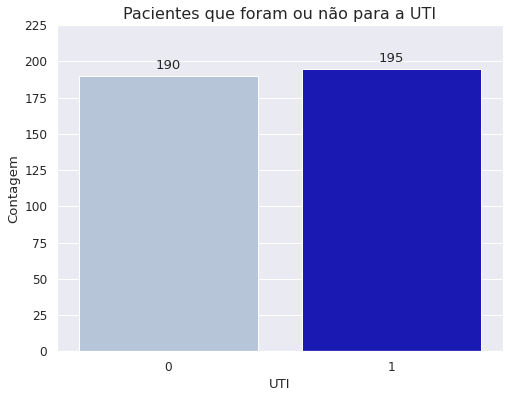

In [ ]:
plt.figure(figsize=(8,6))

ax = sns.countplot(data=dados_eda, x='icu', palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
ax.set_xlabel("UTI")
ax.set_ylabel("Contagem")
ax.set_title("Pacientes que foram ou não para a UTI", fontsize=16)
ax.set_ylim(0, 225)
anotacao(ax)

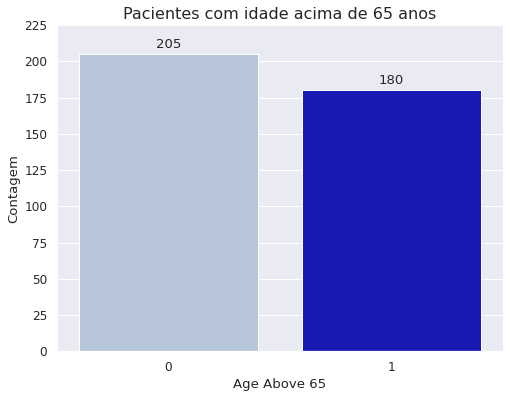

In [ ]:
plt.figure(figsize=(8,6))

ax = sns.countplot(data=dados_eda, x="age_above65", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
ax.set_xlabel("Age Above 65")
ax.set_ylabel("Contagem")
ax.set_title("Pacientes com idade acima de 65 anos", fontsize=16)
ax.set_ylim(0, 225)
anotacao(ax)

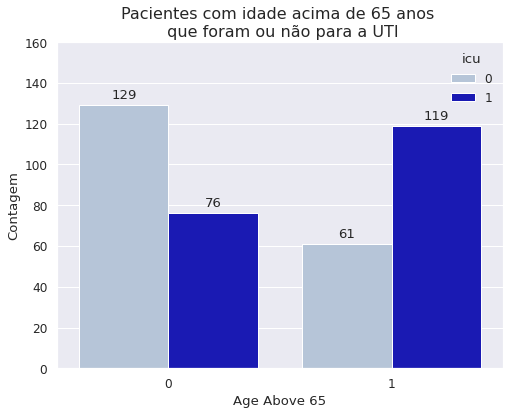

In [ ]:
plt.figure(figsize=(8,6))

ax = sns.countplot(data=dados_eda, x="age_above65", hue="icu", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
ax.set_xlabel("Age Above 65")
ax.set_ylabel("Contagem")
ax.set_title("Pacientes com idade acima de 65 anos \n que foram ou não para a UTI", fontsize=16)
ax.set_ylim(0, 160)
ax.legend(title="icu", loc="upper right")
anotacao(ax)

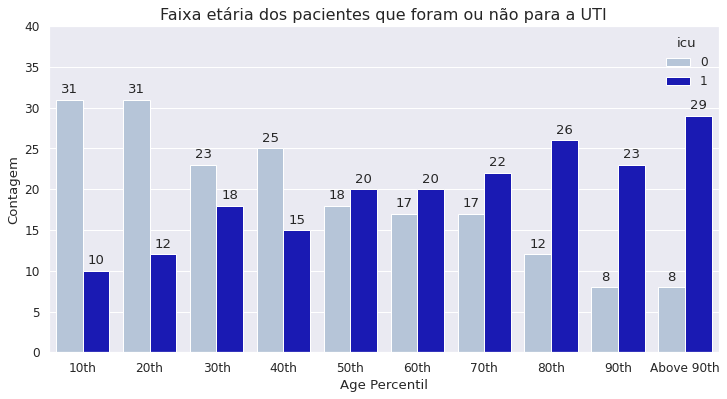

In [ ]:
plt.figure(figsize=(12,6))

ax = sns.countplot(data=dados_eda, x="age_percentil", hue="icu", order=sorted(dados_raw["age_percentil"].unique()), 
                    palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
ax.set_xlabel("Age Percentil")
ax.set_ylabel("Contagem")
ax.set_title("Faixa etária dos pacientes que foram ou não para a UTI", fontsize=16)
ax.set_ylim(0, 40)
anotacao(ax)

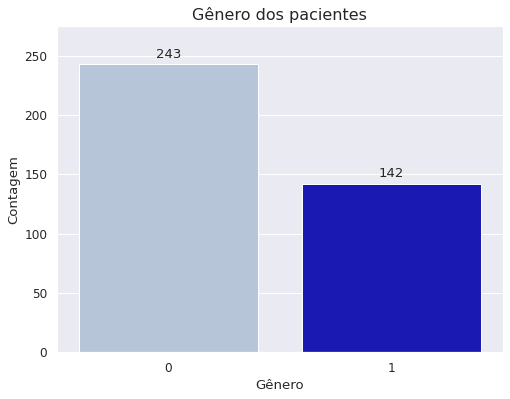

In [ ]:
plt.figure(figsize=(8,6))

ax = sns.countplot(data=dados_eda, x='gender', palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
ax.set_xlabel("Gênero")
ax.set_ylabel("Contagem")
ax.set_title("Gênero dos pacientes", fontsize=16)
ax.set_ylim(0, 275)
anotacao(ax)

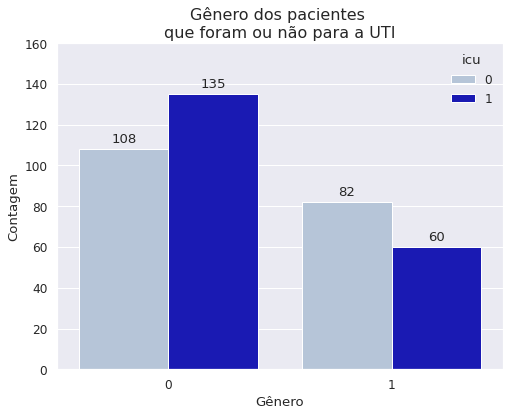

In [ ]:
plt.figure(figsize=(8,6))

ax = sns.countplot(data=dados_eda, x='gender', hue="icu", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
ax.set_xlabel("Gênero")
ax.set_ylabel("Contagem")
ax.set_title("Gênero dos pacientes \nque foram ou não para a UTI", fontsize=16)
ax.set_ylim(0, 160)
anotacao(ax)

Dos 385 pacientes, aproximadamente 51% (195 pacientes) foram para a UTI e 49% (190 pacientes) não foram. Podemos considerar, então, que as classes estão balanceadas.

Cerca de 53% dos pacientes tem idade inferior a 65 anos, o que representa 205 pacientes. Desses pacientes, 76 (37%) foram para a UTI e 129 (63%) não foram.
Dos pacientes com idade superior a 65 anos (180 pacientes), cerca de 66% foram para a UTI e 34% não foram. 

Analisando a faixa etária dos pacientes que foram ou não para a UTI, é possível obervar que com o aumento da idade, aumenta também a chance do paciente ir para a UTI. O contrário também é verdadeiro. Ou seja, a idade parece ser um fator relevante para determinar os pacientes que foram ou não para a UTI.

No que diz respeito ao gênero dos pacientes, cerca de 63% (243 pacientes) é do gênero 0 e 37% (142 pacientes) é do gênero 1. Entre os pacientes do gênero 0, 56% foram pra UTI. Já entre os pacientes do gênero 1, 42% foram para UTI. Isso pode indicar que pacientes do gênero 0 tem maior chance de ir para UTI e que o gênero também é um fator relevante para os modelos de classificação.

### **Doenças pré-existentes**

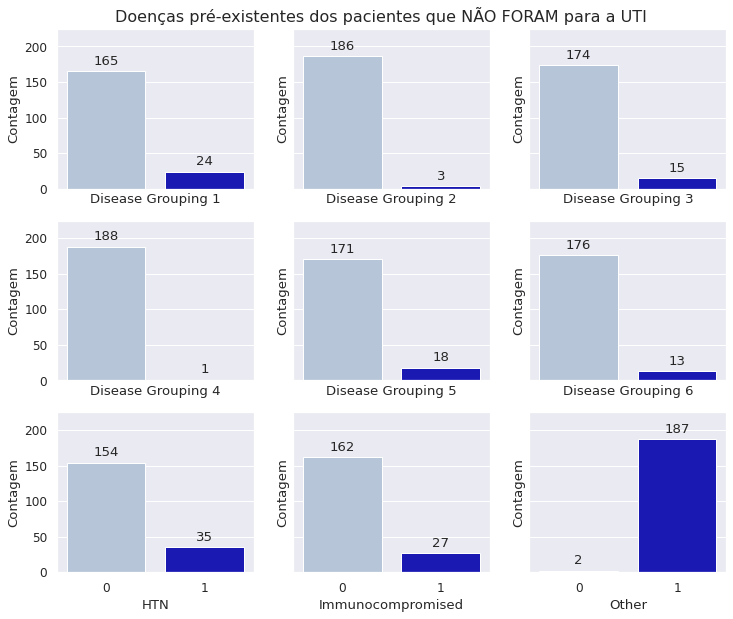

In [ ]:
plota_doencas(0)

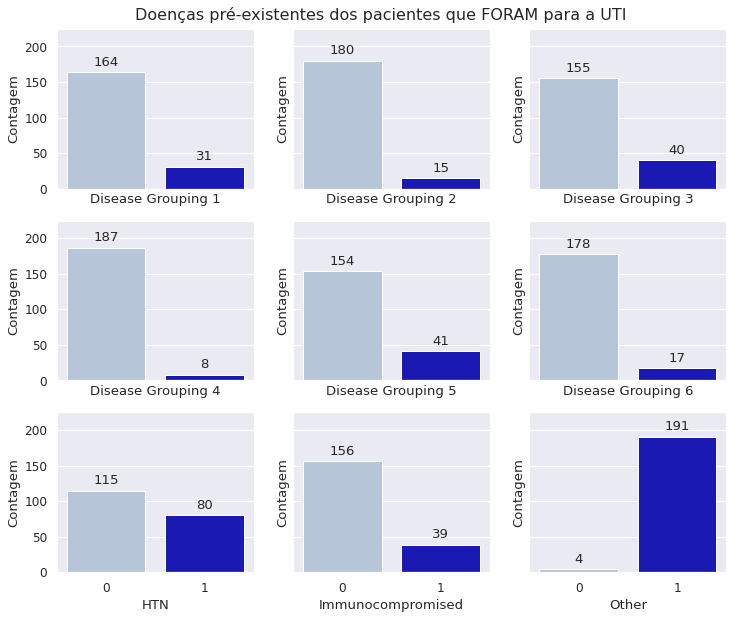

In [ ]:
plota_doencas(1)

Dos 195 pacientes que foram para a UTI, apenas 4 não tinham nenhuma das doenças pré-existentes. Isso significa que cerca de 98% tinham alguma doença.

Já entre os 189 pacientes que não foram para a UTI, 187 tinham alguma das doenças pré-existentes, também algo em torno de 98%. Ou seja, somente a pré-existência de alguma doença não é suficiente para determinar se um paciente foi ou não para a UTI.

Dentre as doenças apresentadas, a *hipertensão* (*htn*) foi a doença com maior incidência entre os pacientes que foram para a UTI (41%). O mesmo se repetiu entre os pacientes que não foram para a UTI, mas em menor proporção (18%). Isso corrobora o fato de pessoas hipertensas estarem no [grupo de risco da Covid-19](https://www.santacasasp.org.br/portal/site/pub/16683/hipertensao-arterial-e-sua-relacao-com-a-covid-19-).

A *Disease Grouping 4* foi a doença com menor incidência tanto entre os pacientes que foram para a UTI quanto entre os pacientes que não foram.

### **Resultados do exame de sangue**

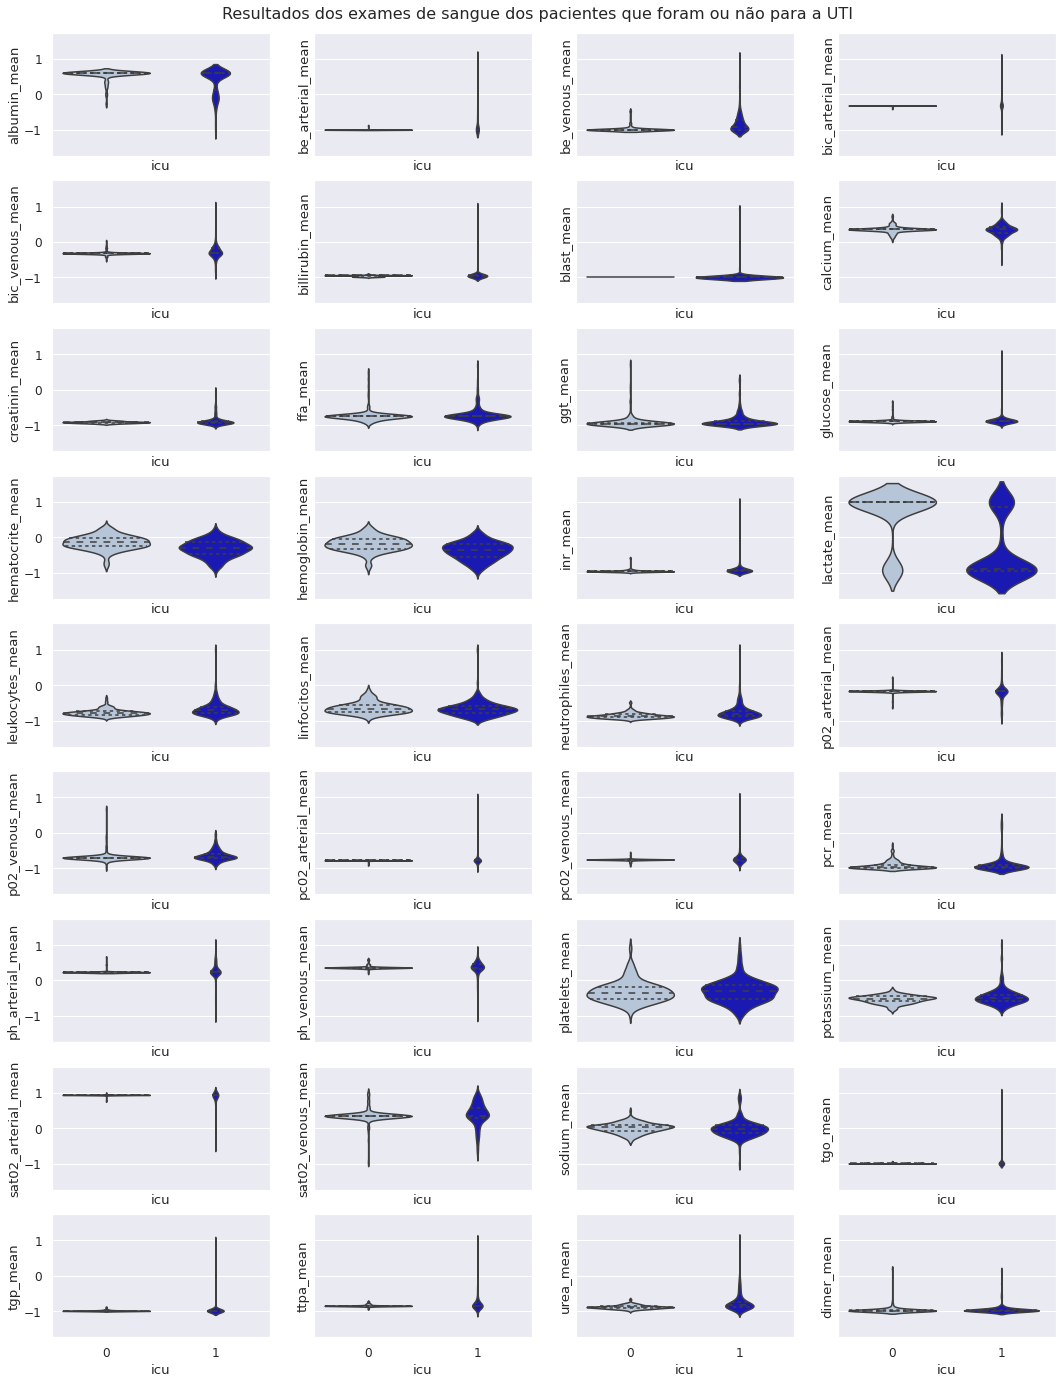

In [ ]:
plota_exame()

Ao analisarmos os resultados dos exames de sangue, observamos distribuições bastante semelhantes para os pacientes que foram e os pacientes que não foram para a UTI.

Apenas o atributo *lactate* apresenta distribuição contrária para os pacientes que foram e não foram para a UTI, o que significa que esse atributo pode ser relevante para os modelos de classificação.


### **Sinais vitais**

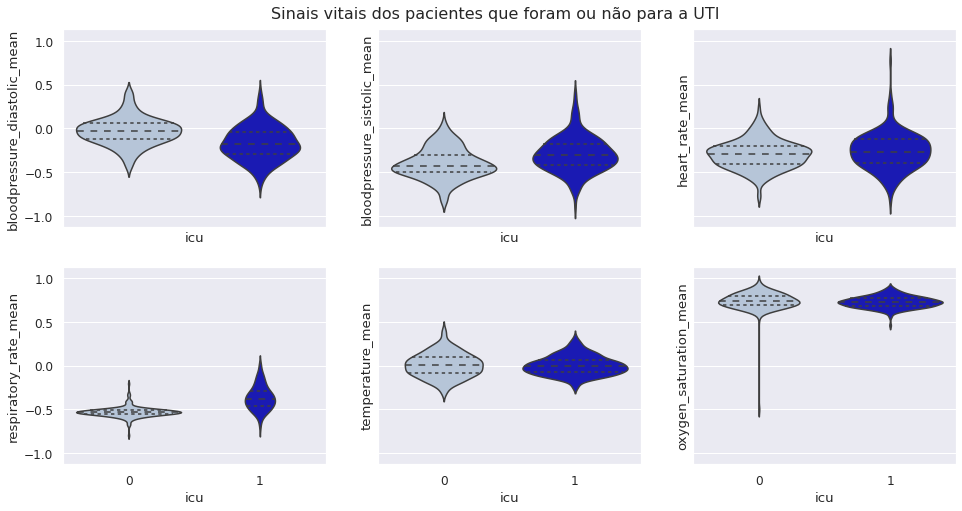

In [161]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)

fig.suptitle("Sinais vitais dos pacientes que foram ou não para a UTI", y=0.92, fontsize=16)
    
ax = sns.violinplot(ax=axes[0, 0], x="icu", y="bloodpressure_diastolic_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
ax = sns.violinplot(ax=axes[0, 1], x="icu", y="bloodpressure_sistolic_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
ax = sns.violinplot(ax=axes[0, 2], x="icu", y="heart_rate_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2))
ax = sns.violinplot(ax=axes[1, 0], x="icu", y="respiratory_rate_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2)) 
ax = sns.violinplot(ax=axes[1, 1], x="icu", y="temperature_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2)) 
ax = sns.violinplot(ax=axes[1, 2], x="icu", y="oxygen_saturation_mean", data=dados_eda, inner="quartile", palette=sns.color_palette("blend:lightsteelblue,mediumblue", 2)) 

Dentre os sinais vitais dos pacientes, a maior diferença entre pacientes que foram ou não para a UTI é observada na distribuição do atributo *respiratory_rate*. A distribuição é mais espalhada para os pacientes que foram para a UTI e estão mais próximas da mediana para os pacientes que não foram para a UTI.

É possível observar também uma diferença na mediana dos atributos *bloodpressure_diastolic* e *bloodpressure_sistolic* para pacientes que foram e não foram para a UTI.

# **PRÉ-PROCESSAMENTO DOS DADOS**

Nesta seção, vamos realizar o pré-processamento dos dados garantindo que estejam em um formato que possibilite sua utilização para criar um modelo de Machine Learning.

Em um primeiro momento, os dados de pacientes que foram admitidos na UTI na primeira janela de tempo (0-2) serão descartados.

Além disso, vamos identificar e lidar com os valores faltantes seguindo as diretrizes do time do Hospital Sírio Libanês.

Ainda seguindo as diretrizes do time do Hospital Sírio Libanês, vamos selecionar a janela de tempo a ser utilizada nos modelos de classificação.

Por fim, vamos transformação a coluna *age_percentil* para garantir que não haja grande discrepância na escala dos valores dos atributos, evitando assim que o desempenho dos modelos seja comprometido.

## **DADOS DE PACIENTES QUE FORAM ADMITIDOS NA UTI NA PRIMEIRA JANELA DE TEMPO**

Conforme as diretrizes do Hospital Sírio Libanês, os dados de pacientes que foram admitidos na UTI na primeira janela de tempo (0-2) não devem ser considerados para as análises.

Para simplificar, esses dados serão desconsiderados desde o primeiro momento.

In [ ]:
dados_primeira_janela_uti = dados_raw.query("window=='0-2' and icu==1")["patient_visit_identifier"].values
dados_usaveis = dados_raw.query("patient_visit_identifier not in @dados_primeira_janela_uti")
print(f"Desconsiderando os dados de pacientes que entraram na UTI na primeira janela de tempo (0-2), são {dados_usaveis.shape[0]} registros e {dados_usaveis.shape[1]} colunas.")

Desconsiderando os dados de pacientes que entraram na UTI na primeira janela de tempo (0-2), são 1765 registros e 231 colunas.


## **DADOS FALTANTES**

In [ ]:
#Exibindo a porcentagem de dados faltantes em cada coluna do dataset
for coluna in dados_raw.columns:
    print(f"{coluna}: {round(dados_raw[coluna].isnull().mean() * 100,2)}%")

patient_visit_identifier: 0.0%
age_above65: 0.0%
age_percentil: 0.0%
gender: 0.0%
disease_grouping_1: 0.26%
disease_grouping_2: 0.26%
disease_grouping_3: 0.26%
disease_grouping_4: 0.26%
disease_grouping_5: 0.26%
disease_grouping_6: 0.26%
htn: 0.26%
immunocompromised: 0.26%
other: 0.26%
albumin_median: 57.35%
albumin_mean: 57.35%
albumin_min: 57.35%
albumin_max: 57.35%
albumin_diff: 57.35%
be_arterial_median: 57.35%
be_arterial_mean: 57.35%
be_arterial_min: 57.35%
be_arterial_max: 57.35%
be_arterial_diff: 57.35%
be_venous_median: 57.35%
be_venous_mean: 57.35%
be_venous_min: 57.35%
be_venous_max: 57.35%
be_venous_diff: 57.35%
bic_arterial_median: 57.35%
bic_arterial_mean: 57.35%
bic_arterial_min: 57.35%
bic_arterial_max: 57.35%
bic_arterial_diff: 57.35%
bic_venous_median: 57.35%
bic_venous_mean: 57.35%
bic_venous_min: 57.35%
bic_venous_max: 57.35%
bic_venous_diff: 57.35%
billirubin_median: 57.35%
billirubin_mean: 57.35%
billirubin_min: 57.35%
billirubin_max: 57.35%
billirubin_diff: 57.35

In [ ]:
print(f"O dataset possui {round(100*dados_usaveis.isna().to_numpy().sum()/(dados_usaveis.shape[0]*dados_usaveis.shape[1]), 2)}% de valores faltantes.\n")

print(f"Número de colunas que possuem valores faltantes: {len(dados_usaveis.columns[dados_usaveis.isna().any()])}")

print(f"\nNúmero de colunas que não possuem valores faltantes: {len(dados_usaveis.columns[dados_usaveis.notna().all()])}")


O dataset possui 51.19% de valores faltantes.

Número de colunas que possuem valores faltantes: 225

Número de colunas que não possuem valores faltantes: 6


O time do Hospital Sírio Libanês sugere a melhor maneira de lidar com os valores faltantes:

>É razoável presumir que um paciente que não tem uma medição registrada em uma determinada janela de tempo esteja clinicamente estável, podendo apresentar sinais vitais e exames de sangue semelhantes às janelas vizinhas. Portanto, pode-se preencher os valores faltantes usando os valores da janela anterior ou posterior. Atenção aos problemas de multicolinearidade e variância zero nesses dados ao escolher seu algoritmo.

In [ ]:
dados_sem_nan = preenche_tabela(dados_usaveis)

#Exibindo as 5 primeiras linhas do dataset após o preenchimento dos valores faltantes
dados_sem_nan.head()

,patient_visit_identifier,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,albumin_median,albumin_mean,albumin_min,albumin_max,albumin_diff,be_arterial_median,be_arterial_mean,be_arterial_min,be_arterial_max,be_arterial_diff,be_venous_median,be_venous_mean,be_venous_min,be_venous_max,be_venous_diff,bic_arterial_median,bic_arterial_mean,bic_arterial_min,bic_arterial_max,bic_arterial_diff,bic_venous_median,bic_venous_mean,bic_venous_min,bic_venous_max,bic_venous_diff,billirubin_median,billirubin_mean,...,dimer_max,dimer_diff,bloodpressure_diastolic_mean,bloodpressure_sistolic_mean,heart_rate_mean,respiratory_rate_mean,temperature_mean,oxygen_saturation_mean,bloodpressure_diastolic_median,bloodpressure_sistolic_median,heart_rate_median,respiratory_rate_median,temperature_median,oxygen_saturation_median,bloodpressure_diastolic_min,bloodpressure_sistolic_min,heart_rate_min,respiratory_rate_min,temperature_min,oxygen_saturation_min,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,bloodpressure_sistolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff,oxygen_saturation_diff,bloodpressure_diastolic_diff_rel,bloodpressure_sistolic_diff_rel,heart_rate_diff_rel,respiratory_rate_diff_rel,temperature_diff_rel,oxygen_saturation_diff_rel,window,icu
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27272

In [ ]:
#Exibindo as linhas que ainda tem valores faltantes
dados_sem_nan[dados_sem_nan.isna().any(axis=1)]

,patient_visit_identifier,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,albumin_median,albumin_mean,albumin_min,albumin_max,albumin_diff,be_arterial_median,be_arterial_mean,be_arterial_min,be_arterial_max,be_arterial_diff,be_venous_median,be_venous_mean,be_venous_min,be_venous_max,be_venous_diff,bic_arterial_median,bic_arterial_mean,bic_arterial_min,bic_arterial_max,bic_arterial_diff,bic_venous_median,bic_venous_mean,bic_venous_min,bic_venous_max,bic_venous_diff,billirubin_median,billirubin_mean,...,dimer_max,dimer_diff,bloodpressure_diastolic_mean,bloodpressure_sistolic_mean,heart_rate_mean,respiratory_rate_mean,temperature_mean,oxygen_saturation_mean,bloodpressure_diastolic_median,bloodpressure_sistolic_median,heart_rate_median,respiratory_rate_median,temperature_median,oxygen_saturation_median,bloodpressure_diastolic_min,bloodpressure_sistolic_min,heart_rate_min,respiratory_rate_min,temperature_min,oxygen_saturation_min,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,bloodpressure_sistolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff,oxygen_saturation_diff,bloodpressure_diastolic_diff_rel,bloodpressure_sistolic_diff_rel,heart_rate_diff_rel,respiratory_rate_diff_rel,temperature_diff_rel,oxygen_saturation_diff_rel,window,icu
995,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.978029,-1.0,0.100944,-0.355656,-0.012209,-0.577268,0.07563,0.653251,0.08642,-0.384615,0.056604,-0.517241,0.107143,0.684211,-0.175258,-0.25,-0.213675,-0.571429,0.252747,0.818182,-0.076923,-0.351351,-0.134328,-0.515152,0.130435,0.736842,-0.478261,-0.631902,-0.648855,-0.823529,-0.595238,-0.919192,-0.608696,-0.607383,-0.790037,-0.817204,-0.599662,-0.918403,0-2,0
996,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.978029,-1.0,0.100944,-0.355656,-0.012209,-0.577268,0.07563,0.653251,0.08642,-0.384615,0.056604,-0.517241,0.107143,0.684211,-0.175258,-0.25,-0.213675,-0.571429,0.252747,0.818182,-0.076923,-0.351351,-0.134328,-0.515152,0.130435,0.736842,-0.478261,-0.631902,-0.648855,-0.823529,-0.595238,-0.919192,-0.608696,-0.607383,-0.790037,-0.817204,-0.599662,-0.918403,2-4,0
997,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.978029,-1.0,0.100944,-0.355656,-0.012209,-0.577268,0.07563,0.653251,0.08642,-0.384615,0.056604,-0.517241,0.107143,0.684211,-0.175258,-0.25,-0.213675,-0.571429,0.252747,0.818182,-0.076923,-0.351351,-0.134328,-0.515152,0.130435,0.736842,-0.478261,-0.631902,-0.648855,-0.823529,-0.595238,-0.919192,-0.608696,-0.607383,-0.790037,-0.817204,-0.599662,-0.918403,4-6,0
998,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.978029,-1.0,0.100944,-0.355656,-0.012209,-0.577268,0.07563,0.653251,0.08642,-0.384615,0.056604,-0.517241,0.107143,0.684211,-0.175258,-0.25,-0.213675,-0.571429,0.252747,0.818182,-0.076923,-0.351351,-0.134328,-0.515152,0.130435,0.736842,-0.478261,-0.631902,-0.648855,-0.823529,-0.595238,-0.919192,-0.608696,-0.607383,-0.790037,-0.817204,-0.599662,-0.918403,6-12,0
999,199,0,10th,0,Na

Como os dados faltantes correspondem a um único paciente, esse paciente será descartado da análise.

In [ ]:
dados_sem_nan = dados_sem_nan.dropna()
imprime_shape(dados_sem_nan)

O dataset agora possui 1760 registros e 231 colunas.


## **SELEÇÃO DA JANELA DE TEMPO**

O ideal para o hospital é que já nas primeiras horas seja possível identificar se o paciente vai ou não para a UTI.
<br>Segundo o time do Hospital Sírio Libanês:
>Ainda que um modelo preditivo usando todas as janelas de tempo provavelmente resulte em uma maior acurácia, um bom modelo usando apenas a primeira janela (0-2) provavelmente será mais relevante clinicamente.

In [ ]:
dados_limpos = dados_sem_nan.groupby("patient_visit_identifier").apply(prepara_janela)

Como a janela de tempo é a mesma para todos os pacientes, a coluna *window* não será relevante para o treinamento dos modelos de Machine Learning e será excluída do dataset.

In [ ]:
#Descartando a coluna "window"
dados_limpos = dados_limpos.drop(["window"], axis=1)

O número identificador do paciente também não é relevante para os modelos de Machine Learning e será utilizado com índice.

In [ ]:
#Descartando a coluna "patient_visit_identifier"
dados_limpos.set_index("patient_visit_identifier", inplace=True)

In [ ]:
imprime_shape(dados_limpos)

O dataset agora possui 352 registros e 229 colunas.


## **TRANSFORMAÇÃO DA COLUNA *AGE_PERCENTIL***

A coluna *age_percentil* será transformada de modo que os valores estejam entre 0 e 1, inclusive, para garantir que não haja grande discrepância na escala dos valores dos atributos.

In [ ]:
dados_limpos["age_percentil"]

patient_visit_identifier
0            60th
2            10th
3            40th
4            10th
5            10th
          ...    
380          40th
381    Above 90th
382          50th
383          40th
384          50th
Name: age_percentil, Length: 352, dtype: object

In [ ]:
dados_limpos["age_percentil"] = dados_limpos["age_percentil"].str.replace(r'\D', '').astype("int64")
dados_limpos["age_percentil"] = normalize_data(dados_limpos["age_percentil"])
dados_limpos["age_percentil"]

patient_visit_identifier
0      0.625
2      0.000
3      0.375
4      0.000
5      0.000
       ...  
380    0.375
381    1.000
382    0.500
383    0.375
384    0.500
Name: age_percentil, Length: 352, dtype: float64

# **AVALIAÇÃO DOS MODELOS DE CLASSIFICAÇÃO - PARTE 1**

Nesta seção, vamos avaliar o desempenho de um conjunto de modelos de classificação com seus parâmetros padrão para determinar qual tem o melhor desempenho com o dataset *dados_limpos_base* contendo todos os atributos. 

Isso é necessário para vermos como os ajustes nos dados e nos parâmetros do modelo que serão feitos a seguir podem causar melhorias no desempenho do modelo.

Os modelos de classificação serão instanciados com seus parâmetros padrão e adicionados a uma lista de modelos.


<img src="https://github.com/claricefiorese/bootcamp_alura_projetos/blob/main/projeto_final/7.png?raw=true" width="228" height="235"/>

In [ ]:
dados_limpos_base = dados_limpos.copy()
imprime_shape(dados_limpos_base)

O dataset agora possui 352 registros e 229 colunas.


**Modelos de classificação**

Segundo o livro *Machine Learning Pocket Reference*, de Matt Harrison:
>A classificação é um método de aprendizagem supervisionada (supervised
learning) para atribuir um rótulo a uma amostra com base nos atributos.
<br>A aprendizagem supervisionada implica que temos rótulos para classificação, os quais o algoritmo deve aprender.


<img src="https://raw.githubusercontent.com/claricefiorese/bootcamp_alura_projetos/main/projeto_final/6.png" width="605" height="250"/>


**Métrica de avaliação**

O desempenho dos modelos de classificação será avaliado pela métrica *roc_auc*. Quanto maior esse valor, melhor o desempenho do modelo em prever 0s como 0s e 1s como 1s. Ou seja, quanto maior a *roc_auc*, melhor o desempenho do modelo em distinguir entre pacientes que foram para UTI e pacientes que não foram para a UTI.

Maiores informações sobre esta métrica podem ser encontradas neste [link](https://medium.com/@eam.avelar/o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-2e2c4112033d).



**Métodos de avaliação**

Sempre devemos evitar treinar e testar o modelo nos mesmos dados. Isso porque o objetivo do modelo é prever a partir de dados que ainda não tenham sido vistos antes. 

Para minimizar o overfitting, existem dois cuidados:
- Train/Test Split
- Validação cruzada K-Fold

**Train/Test Split**: este método divide o dataset em conjunto de treino e de teste. Além disso, as amostras são estratificadas (processo em que cada classe de saída deve ser representada com proporções iguais em cada um dos conjuntos). O conjunto de treino é usado para treinar o modelo, e o conjunto de teste é usado para testar o modelo e avaliar o seu desempenho. 


<img src="https://github.com/claricefiorese/bootcamp_alura_projetos/blob/main/projeto_final/1.png?raw=true" width="305" height="140"/>

No caso desse projeto, usaremos 70% da totalidade dos dados para treino e 30% para teste.

In [ ]:
#Separando o dataset em treino e de teste, treinando e testando os modelos de classificação e avaliando o desempenho de cada modelo
calcula_score_treino_teste(dados_limpos_base)

,Modelo,ROC-AUC
0,Dummy Classifier,0.467240
1,K-Nearest Neighbors Classifier,0.620838
2,Support Vector Classifier,0.760652
3,Logistic Regression,0.754923
4,Decision Tree Classifier,0.588435
5,Naive Bayes,0.542248
6,Random Forest Classifier,0.731472
7,Gradient Boosting Classifier,0.730039


**Validação cruzada K-Fold**: este método divide o dataset em K partições iguais (folds), e então usa uma partição como conjunto de teste e as demais como conjunto de treino. Em seguida, o modelo é testado quanto ao desempenho. As etapas acima são repetidas K vezes, usando partições diferentes como conjunto de teste a cada vez. O desempenho do modelo é o desempenho médio após as K repetições.


<img src="https://github.com/claricefiorese/bootcamp_alura_projetos/blob/main/projeto_final/2.png?raw=true" width="305" height="325"/>

No caso deste projeto, será utilizada a *StratifiedKFold*, uma variação da validação cruzada K-Fold que retorna partições estratificadas, e K igual a 10.

In [ ]:
#Separando as variáveis de entrada e a variável alvo e avaliando os modelos de classificação usando a validação cruzada "StratifiedKFold"
calcula_score_cross_val(dados_limpos_base)

,Modelo,ROC-AUC
0,Dummy Classifier,0.461380
1,K-Nearest Neighbors Classifier,0.694208
2,Support Vector Classifier,0.787870
3,Logistic Regression,0.771648
4,Decision Tree Classifier,0.632733
5,Naive Bayes,0.722702
6,Random Forest Classifier,0.780969
7,Gradient Boosting Classifier,0.798667


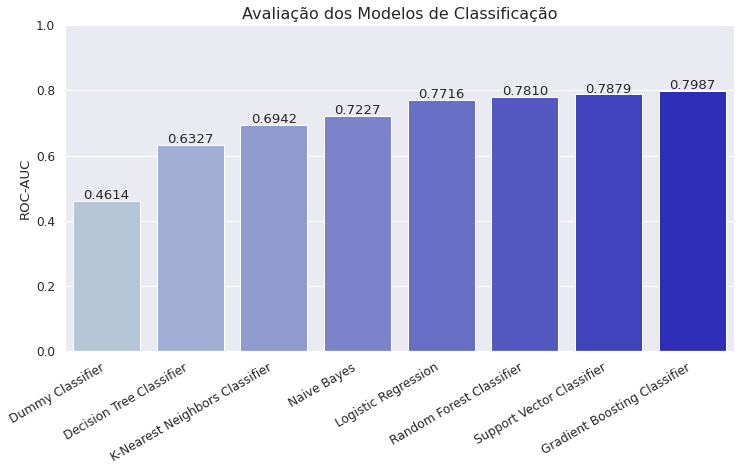

In [ ]:
#Plotando o gráfico comparativo de auc para cada modelo de classificação
data = calcula_score_cross_val(dados_limpos_base)
data = data.sort_values(by="ROC-AUC")

plt.figure(figsize=(12,6))

ax = sns.barplot(x="Modelo", y="ROC-AUC", data=data, palette=sns.color_palette("blend:lightsteelblue,mediumblue", 9))
ax.set_ylabel("ROC-AUC")
ax.set_xlabel("")
ax.set_ylim(0, 1)
ax.set_title("Avaliação dos Modelos de Classificação", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

# **SELEÇÃO DE ATRIBUTOS - PARTE 1**

Nesta seção, vamos começar a selecionar os atributos que são úteis para os modelos de classificação evitando, assim, que atributos irrelevantes causem um efeito negativo no desempenho desses modelos.
Esse processo contribui também para otimizar o tempo de treinamento dos dados que, em geral, é uma função do número de colunas.

Antes de começarmos a seleção de atributos, vamos adicionar ao dataset os atributos selecionados pelo time do Hospital Sírio Libanês.

Em seguida, vamos eliminar os atributos com valores únicos e as colunas duplicadas.

Vamos ainda utilizar um *Filter Method* para a seleção de atributos.


## **ATRIBUTOS SELECIONADOS PELO TIME DO HOSPITAL SÍRIO LIBANÊS**

A função *makebio_df* foi criada pelo time do Hospital Sírio Libanês para adicionar novos atributos e selecionar aqueles considerados mais relevantes do ponto de vista biológico.
A partir disso, será criado o dataset *dados_sirio* contendo apenas esses atributos.

In [ ]:
dados_limpos_antes_sirio = dados_limpos.copy()
dados_sirio = makebio_df(dados_limpos_antes_sirio)
imprime_shape(dados_sirio)

O dataset agora possui 352 registros e 17 colunas.


Para a continuação das análises, os atributos selecionados pelo time do Hospital Sírio Libanês serão adicionados ao dataset *dados_limpos*.

Vale ressaltar que, ainda que esses atributos sejam relevantes do ponto de vista biológico, pode acontecer de não serem relevantes para os modelos de classificação e acabarem sendo eliminados nos processos de seleção de atributos.

In [ ]:
dados_com_atributos_sirio = adiciona_atributos(dados_sirio, dados_limpos)
imprime_shape(dados_com_atributos_sirio)

O dataset agora possui 352 registros e 231 colunas.


## **ELIMINANDO ATRIBUTOS COM VALORES ÚNICOS**

Os atributos com valores únicos serão descartados por não serem relevantes para diferenciar os pacientes que foram admitidos ou não na UTI.

In [ ]:
for coluna in dados_com_atributos_sirio.columns:
    if len(dados_com_atributos_sirio[coluna].unique()) == 1:
      print(coluna)
      dados_com_atributos_sirio.drop(coluna,inplace=True,axis=1)

albumin_diff
be_arterial_diff
be_venous_diff
bic_arterial_diff
bic_venous_diff
billirubin_diff
blast_diff
calcium_diff
creatinin_diff
ffa_diff
ggt_diff
glucose_diff
hematocrite_diff
hemoglobin_diff
inr_diff
lactate_diff
leukocytes_diff
linfocitos_diff
neutrophiles_diff
p02_arterial_diff
p02_venous_diff
pc02_arterial_diff
pc02_venous_diff
pcr_diff
ph_arterial_diff
ph_venous_diff
platelets_diff
potassium_diff
sat02_arterial_diff
sat02_venous_diff
sodium_diff
tgo_diff
tgp_diff
ttpa_diff
urea_diff
dimer_diff
gaso


In [ ]:
imprime_shape(dados_com_atributos_sirio)

O dataset agora possui 352 registros e 194 colunas.


## **ELIMINANDO COLUNAS DUPLICADAS**

As colunas duplicadas serão identificadas e eliminadas por serem redundantes para os modelos de classificação.

In [ ]:
colunas_valores_identicos = getDuplicateColumns(dados_com_atributos_sirio)
for coluna in colunas_valores_identicos:
  print(coluna)

urea_max
calcium_max
ph_arterial_mean
inr_max
ttpa_max
ffa_min
albumin_max
dimer_mean
hematocrite_max
creatinin_max
sat02_venous_mean
billirubin_mean
albumin_min
sat02_venous_min
ggt_max
pc02_arterial_mean
p02_venous_mean
potassium_mean
hemoglobin_min
billirubin_max
sodium_max
creatinin_min
glucose_max
sat02_arterial_mean
pc02_arterial_min
pc02_venous_mean
p02_arterial_max
sat02_venous_max
platelets_min
ph_venous_min
be_arterial_mean
lactate_min
billirubin_min
platelets_max
be_arterial_max
inr_min
hematocrite_min
calcium_min
pcr_max
leukocytes_max
ttpa_min
bic_arterial_min
pcr_min
albumin_mean
be_venous_mean
tgp_mean
p02_venous_min
bic_arterial_mean
p02_venous_max
pc02_arterial_max
ph_venous_mean
bic_venous_mean
sat02_arterial_min
linfocitos_mean
be_arterial_min
creatinin_mean
urea_mean
potassium_max
ffa_max
blast_mean
neutrophiles_min
ggt_mean
pcr_mean
p02_arterial_mean
inr_mean
pc02_venous_max
blast_max
sodium_min
tgp_max
glucose_min
glucose_mean
ph_arterial_max
urea_min
be_venous_mi

In [ ]:
dados_com_atributos_sirio = dados_com_atributos_sirio.drop(colunas_valores_identicos, axis=1)
imprime_shape(dados_com_atributos_sirio)

O dataset agora possui 352 registros e 86 colunas.


## **FILTER METHOD  - CORRELAÇÃO DE PEARSON**

Este método para seleção de atributos é independente de quaisquer algoritmos de Machine Learning e usa a métrica selecionada para avaliar o valor das informações em cada coluna. 

Os atributos são selecionados com base em suas pontuações em testes estatísticos: escolhida uma medida estatística que atenda aos dados, uma pontuação para cada coluna é calculada e os atributos são classificados pela pontuação para serem mantidos ou removidos do modelo.


<img src="https://github.com/claricefiorese/bootcamp_alura_projetos/blob/main/projeto_final/3.png?raw=true" width="605" height="55"/>




Um dos métodos mais simples é a avaliação do coeficiente de correlação de Pearson. Para duas variáveis contínuas quaisquer, ele retorna um valor que indica a intensidade da correlação.

Esse coeficiente varia de -1 a +1 e é calculado usando a covariância de duas variáveis e dividindo-se pelo produto de seus desvios padrão.

Neste caso, serão eliminadas as colunas com um coeficiente de correlação maior que 0,90 por não agregarem valor e poderem prejudicar a interpretação da importância dos atributos.

In [ ]:
colunas = [coluna for coluna in dados_com_atributos_sirio if coluna != "icu"] + ["icu"]
dados_com_atributos_sirio = dados_com_atributos_sirio[colunas]

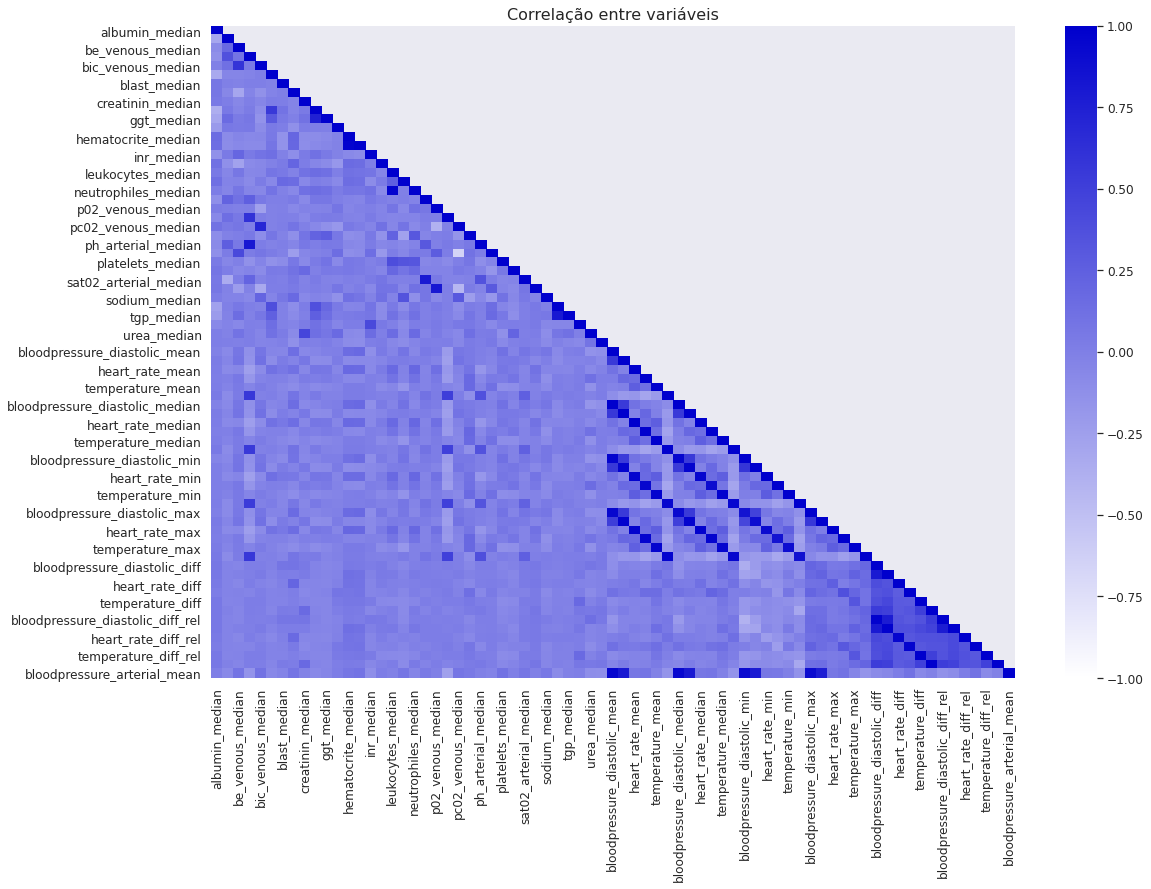

In [ ]:
#Plotando a correlação entre as colunas do dataset "dados_com_atributos_sirio"
plota_correlacao(dados_com_atributos_sirio);

In [ ]:
#Calculando a correlação de Pearson entre as colunas e selecionando aquelas que tem correlação maior que 0,90
colunas_colineares = avalia_correlacao(dados_com_atributos_sirio, 0.90) 

A coluna *bloodpressure_arterial_mean* criada pelo time do Hospital Sírio Libanês e as colunas *bloodpressure_sistolic_mean* e *bloodpressure_diastolic_mean* estão altamente correlacionadas.

Por opção, vamos manter o atributo sugerido pelo time do Hospital Sírio Libanês e eliminar os outros dois.

In [ ]:
colunas_colineares.append("bloodpressure_sistolic_mean")
colunas_colineares.append("bloodpressure_diastolic_mean")
colunas_colineares.remove("bloodpressure_arterial_mean")

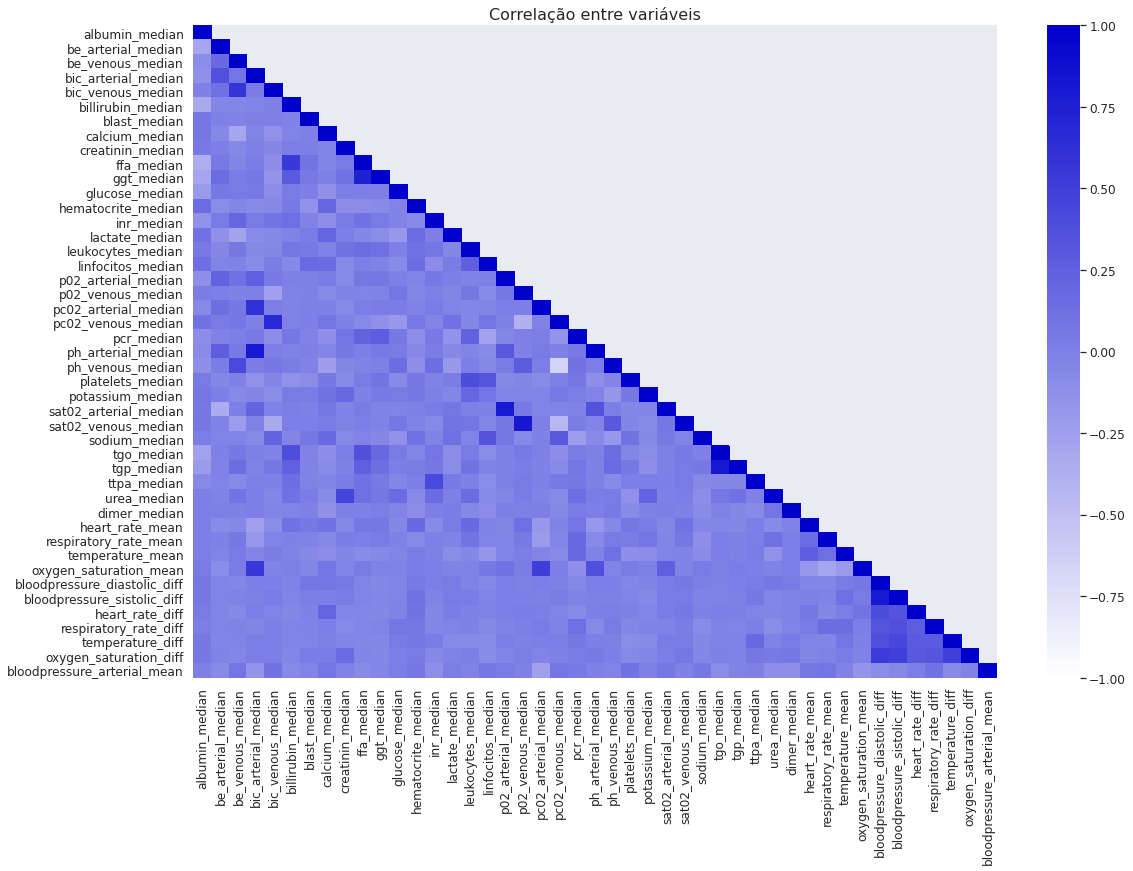

In [ ]:
#Eliminando as colunas colineares e plotando a correlação entre as colunas do dataset "dados_sem_correlacao"
dados_sem_correlacao = dados_com_atributos_sirio.drop(colunas_colineares, axis=1)
plota_correlacao(dados_sem_correlacao);

In [ ]:
imprime_shape(dados_sem_correlacao)

O dataset agora possui 352 registros e 58 colunas.


# **AVALIAÇÃO DOS MODELOS DE CLASSIFICAÇÃO - PARTE 2**

Nesta seção, o desempenho do conjunto de modelos de classificação será avaliado novamente, seguindo o que foi feito na *PARTE 1*, para determinar qual tem o melhor desempenho com o dataset *dados_sem_correlacao*.


In [ ]:
#Separando o dataset em treino e de teste, treinando e testando os modelos de classificação e avaliando o desempenho de cada modelo
calcula_score_treino_teste(dados_sem_correlacao)

,Modelo,ROC-AUC
0,Dummy Classifier,0.467240
1,K-Nearest Neighbors Classifier,0.616362
2,Support Vector Classifier,0.775152
3,Logistic Regression,0.795739
4,Decision Tree Classifier,0.575367
5,Naive Bayes,0.562657
6,Random Forest Classifier,0.734336
7,Gradient Boosting Classifier,0.711063


In [ ]:
#Separando as variáveis de entrada e a variável alvo e avaliando os modelos de classificação usando a validação cruzada "StratifiedKFold"
calcula_score_cross_val(dados_sem_correlacao)

,Modelo,ROC-AUC
0,Dummy Classifier,0.461380
1,K-Nearest Neighbors Classifier,0.684061
2,Support Vector Classifier,0.761872
3,Logistic Regression,0.766273
4,Decision Tree Classifier,0.638452
5,Naive Bayes,0.714595
6,Random Forest Classifier,0.793296
7,Gradient Boosting Classifier,0.799665


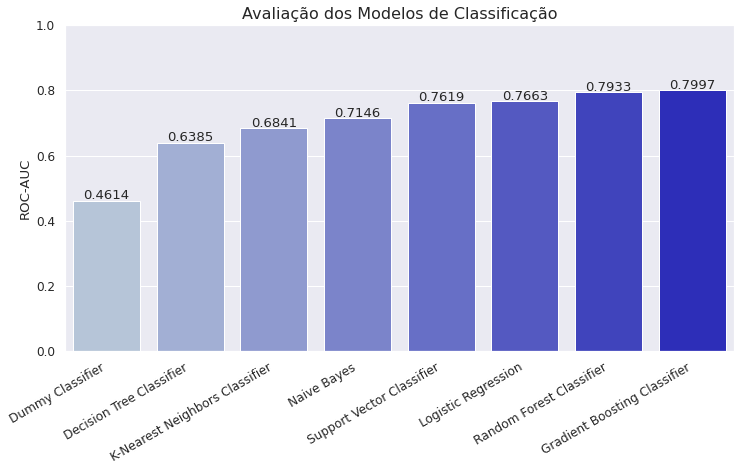

In [ ]:
#Plotando o gráfico comparativo de auc para cada modelo de classificação
data = calcula_score_cross_val(dados_sem_correlacao)
data = data.sort_values(by="ROC-AUC")

plt.figure(figsize=(12,6))

ax = sns.barplot(x="Modelo", y="ROC-AUC", data=data, palette=sns.color_palette("blend:lightsteelblue,mediumblue", 9))
ax.set_ylabel("ROC-AUC")
ax.set_xlabel("")
ax.set_ylim(0, 1)
ax.set_title("Avaliação dos Modelos de Classificação", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

É possível observar que *Gradient Boosting Classifier* e *Random Forest Classifier* tiveram um desempenho melhor que os outros modelos e, por isso, serão utilizados na próxima seção.

# **SELEÇÃO DE ATRIBUTOS - PARTE 2**

Nesta seção, vamos seguir com a seleção de atributos utilizando um *Wrapper Method*.

## **WRAPPER METHOD - RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION**

Este método de seleção seleciona um conjunto de atributos, onde diferentes combinações são preparadas, avaliadas e comparadas. 

Um modelo preditivo é usado para avaliar a combinação de atributos testando diretamente seu impacto no desempenho do modelo.

Uma desvantagem dessa abordagem é que testar todas as combinações possíveis de atributos pode ser muito caro do ponto de vista computacional, sobretudo se o conjunto de atributos for muito grande.


<img src="https://github.com/claricefiorese/bootcamp_alura_projetos/blob/main/projeto_final/4.png?raw=true"width="645" height="210"/>

A ideia por trás de Recursive Feature Elimination (RFE) é treinar um modelo repetidamente e eliminar o atributo de pior desempenho em cada iteração.

Na primeira vez que treinamos o modelo, incluímos todos os atributos. Em seguida, encontramos o atributo com a menor pontuação, o que significa que é menos importante para o modelo, e removemos o atributo do conjunto de atributos.

É possível usar validação cruzada (CV) para encontrar o número ideal de atributos a serem mantidos durante a RFE. 

Especificamente, na RFE com CV, após cada iteração, usamos validação cruzada para avaliar o modelo. Se a CV mostrar que nosso modelo melhorou depois que eliminamos um atributo, seguimos para a próxima iteração. No entanto, se a CV mostrar que o modelo piorou depois que eliminamos um atributo, colocamos esse atributo de volta no conjunto de atributos e ele é selecionado como um atributo importante para o modelo.

No Scikit-Learn, RFE com CV é implementada usando RFECV e recebe parâmetros importantes: 

- estimator: determina o tipo de modelo a ser treinado;
- step: define o número ou proporção de atributos a serem eliminados a cada iteração; 
- cv: determina a técnica de validação cruzada a ser usada;
- scoring: define a métrica de avaliação a ser usada para avaliar o modelo durante a validação cruzada.

### **Gradient Boosting Classifier**

Vamos analisar o modelo *Gradient Boosting Classifier*, que teve melhor desempenho na seção anterior, para posteriormente avaliar se o processo de seleção de atributos aumenta o desempenho do modelo.

In [ ]:
dados_rfecv = dados_sem_correlacao.copy()

In [ ]:
#Separando as variáveis de entrada e a variável alvo
x, y = separa_xy(dados_rfecv)
cv = StratifiedKFold(10, random_state=433011, shuffle=True)

In [ ]:
gbc = GradientBoostingClassifier()
rfecv_gbc = RFECV(estimator=gbc, step=1, cv=cv, scoring="roc_auc")
rfecv_gbc.fit(x, y)

KeyboardInterrupt: ignored

In [ ]:
print ("Número ideal de atributos:", rfecv_gbc.n_features_)

In [ ]:
#Plotando o gráfico do número de atributos e o valor da "ROC-AUC" correspondente
plt.figure(figsize=(12,6))

ax = sns.lineplot(range(1, len(rfecv_gbc.grid_scores_) + 1), rfecv_gbc.grid_scores_, color="mediumblue") 
ax.axvline(34, c="k", ls="--")
bbox = dict(boxstyle ="round", fc ="0.8")
ax.annotate(s="n_features = 34 \n score = 0.804", xy=(34, 0.804), xycoords="data", xytext=(19, 0.654),
            bbox=dict(boxstyle ="round", fc ="0.8"), arrowprops=dict(arrowstyle="->", color="gray"))
ax.set_xlabel("Número de atributos selecionados") 
ax.set_ylabel("Cross Validation Score") 
ax.set_title("RFECV - Gradient Boosting Classifier", fontsize=16)
ax.set_ylim(0.55, 0.85)

plt.show()

In [ ]:
x.drop(x.columns[np.where(rfecv_gbc.support_ == False)[0]], axis=1, inplace=True)
dados_rfecv_gbc = pd.DataFrame({"feature_names": x.columns, "feature_importance": rfecv_gbc.estimator_.feature_importances_})
dados_rfecv_gbc = dados_rfecv_gbc.sort_values(by="feature_importance", ascending=False)

plt.figure(figsize=(12,12))

sns.barplot(x=dados_rfecv_gbc["feature_importance"], y=dados_rfecv_gbc["feature_names"], 
            palette=sns.color_palette("blend:mediumblue,lightsteelblue", 34))
plt.title("Importância de cada atributo - Gradient Boosting Classifier", fontsize=16)
plt.xlabel ("Feature importance")

plt.show()

In [ ]:
#Criando um dataset apenas com as colunas selecionadas
colunas_gbc = list(dados_rfecv_gbc["feature_names"])
colunas_gbc.append("icu")
dados_gbc = dados_rfecv[colunas_gbc]
imprime_shape(dados_gbc)

### **Random Forest Classifier**

Vamos analisar também o modelo que teve o segundo melhor desempenho, o *Random Forest Classifier*, para em um segundo momento avaliar se o processo de seleção de atributos interfere no desempenho do modelo e se ele será melhor que o *Gradient Boosting Classifier* após o processo.

In [ ]:
#Separando as variáveis de entrada e a variável alvo
x, y = separa_xy(dados_rfecv)
cv = StratifiedKFold(10, random_state=433011, shuffle=True)

In [ ]:
rfc = RandomForestClassifier()
rfecv_rfc = RFECV(estimator=rfc, step=1, cv=cv, scoring="roc_auc")
rfecv_rfc.fit(x, y)

In [ ]:
print ("Número ideal de atributos:", rfecv_rfc.n_features_)

In [ ]:
#Plotando o gráfico do número de atributos e o valor da "ROC-AUC" correspondente
plt.figure(figsize=(12,6))

ax = sns.lineplot(range(1, len(rfecv_rfc.grid_scores_) + 1), rfecv_rfc.grid_scores_, color="mediumblue") 
ax.axvline(56, c="k", ls="--")
bbox = dict(boxstyle ="round", fc ="0.8")
ax.annotate(s="n_features = 56 \n score = 0.812", xy=(56, 0.812), xycoords="data", xytext=(41, 0.662),
            bbox=dict(boxstyle ="round", fc ="0.8"), arrowprops=dict(arrowstyle="->", color="gray"))
ax.set_xlabel("Número de atributos selecionados") 
ax.set_ylabel("Cross Validation Score") 
ax.set_title("RFECV - Random Forest Classifier", fontsize=16)
ax.set_ylim(0.55, 0.85)

plt.show()

In [ ]:
x.drop(x.columns[np.where(rfecv_rfc.support_ == False)[0]], axis=1, inplace=True)
dados_rfecv_rfc = pd.DataFrame({"feature_names": x.columns, "feature_importance": rfecv_rfc.estimator_.feature_importances_})
dados_rfecv_rfc = dados_rfecv_rfc.sort_values(by="feature_importance", ascending=False)

plt.figure(figsize=(12,12))

sns.barplot(x=dados_rfecv_rfc["feature_importance"], y=dados_rfecv_rfc["feature_names"], 
            palette=sns.color_palette("blend:mediumblue,lightsteelblue", 56))
plt.title("Importância de cada atributo - Random Forest Classifier", fontsize=16)
plt.xlabel ("Feature importance")

plt.show()

In [ ]:
#Criando um dataset apenas com as colunas selecionadas
colunas_rfc = list(dados_rfecv_rfc["feature_names"])
colunas_rfc.append("icu")
dados_rfc = dados_rfecv[colunas_rfc]
imprime_shape(dados_rfc)

# **AVALIAÇÃO DOS MODELOS DE CLASSIFICAÇÃO - PARTE 3**

Nesta terceira parte de avaliação dos modelos de classificação
Nesta seção, o desempenho do conjunto de modelos de classificação será avaliado novamente, seguindo o que foi feito na *PARTE 1*, para determinar qual tem o melhor desempenho com o dataset *dados_sem_correlacao*.

Como a base de dados gerada após RFECV ainda é grande (68 variáveis) e o desempenho de alguns modelos não foi melhor do que com a base mais completa (229 colunas), selecionarei as 20 principais variáveis através do Feature Importances do Extra Trees Classifier, gerando um novo dataframe (dados_limpos3):

## **Gradient Boosting Classifier**

Vamos avaliar o desempenho dos modelos de classificação para determinar qual tem o melhor desempenho com o dataset *dados_gbc*.

Esse dataset contém apenas os atributos selecionados na seção anterior utilizando o modelo *Gradient Boosting Classifier* como *estimator*.

In [ ]:
#Separando o dataset em treino e de teste, treinando e testando os modelos de classificação e avaliando o desempenho de cada modelo
calcula_score_treino_teste(dados_gbc)

In [ ]:
#Separando as variáveis de entrada e a variável alvo e avaliando os modelos de classificação usando a validação cruzada "StratifiedKFold"
calcula_score_cross_val(dados_gbc)

In [ ]:
#Plotando o gráfico comparativo de auc para cada modelo de classificação
plt.figure(figsize=(12,6))

data = calcula_score_cross_val(dados_gbc)
data = data.sort_values(by="ROC-AUC")

ax = sns.barplot(x="Modelo", y="ROC-AUC", data=data, palette=sns.color_palette("blend:lightsteelblue,mediumblue", 9))
ax.set_xlabel("")
ax.set_ylabel("ROC-AUC")
ax.set_ylim(0, 1)
ax.set_title("ROC-AUC dos Modelos de Classificação", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

## **Random Forest Classifier**

Vamos avaliar também o desempenho dos modelos de classificação para determinar qual tem o melhor desempenho com o dataset *dados_rfc*.

Esse dataset contém apenas os atributos selecionados na seção anterior utilizando o modelo *Random Forest Classifier* como *estimator*.

In [ ]:
#Separando o dataset em treino e de teste, treinando e testando os modelos de classificação e avaliando o desempenho de cada modelo
calcula_score_treino_teste(dados_rfc)

In [ ]:
#Separando as variáveis de entrada e a variável alvo e avaliando os modelos de classificação usando a validação cruzada "StratifiedKFold"
calcula_score_cross_val(dados_rfc)

In [ ]:
#Plotando o gráfico comparativo de auc para cada modelo de classificação
plt.figure(figsize=(12,6))

data = calcula_score_cross_val(dados_rfc)
data = data.sort_values(by="ROC-AUC")

ax = sns.barplot(x="Modelo", y="ROC-AUC", data=data, palette=sns.color_palette("blend:lightsteelblue,mediumblue", 9))
ax.set_xlabel("")
ax.set_ylabel("ROC-AUC")
ax.set_ylim(0, 1)
ax.set_title("Avaliação dos Modelos de Classificação", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

Buscando melhorar ainda mais o desempenho dos modelos, vamos avaliar o dataset *dados_rfc_fi*.

Esse dataset é composto pelos atributos que foram selecionados utilizando o modelo *Random Forest Classifier* como *estimator* e que tiveram *feature_importance* maior que 0,009.

In [ ]:
dados_rcf_fi = dados_rfecv_rfc[dados_rfecv_rfc["feature_importance"] > 0.009]
colunas_rcf_fi = list(dados_rcf_fi["feature_names"])
colunas_rcf_fi.append("icu")
dados_rcf_fi = dados_rfecv[colunas_rcf_fi]
imprime_shape(dados_rcf_fi)

In [ ]:
#Separando o dataset em treino e de teste, treinando e testando os modelos de classificação e avaliando o desempenho de cada modelo
calcula_score_treino_teste(dados_rcf_fi)

In [ ]:
#Separando as variáveis de entrada e a variável alvo e avaliando os modelos de classificação usando a validação cruzada "StratifiedKFold"
calcula_score_cross_val(dados_rcf_fi)

In [ ]:
#Plotando o gráfico comparativo de auc para cada modelo de classificação
plt.figure(figsize=(12,6))

data = calcula_score_cross_val(dados_rcf_fi)
data = data.sort_values(by="ROC-AUC")

ax = sns.barplot(x="Modelo", y="ROC-AUC", data=data, palette=sns.color_palette("blend:lightsteelblue,mediumblue", 9))
ax.set_xlabel("")
ax.set_ylabel("ROC-AUC")
ax.set_ylim(0, 1)
ax.set_title("Avaliação dos Modelos de Classificação", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

# **OTIMIZAÇÃO DE PARÂMETROS**

Os modelos têm hiperparâmetros que controlam o seu comportamento. Ao
variar os valores desses parâmetros, alteramos o desempenho dos modelos. 

Em vez de ter que pesquisar manualmente os parâmetros ideais, o *Scikit-Learn* tem uma classe de busca em grade (*GridSearchCV*) para avaliar um modelo com diferentes combinações de parâmetros, devolvendo o melhor resultado.

*GridSearchCV* realiza também uma validação cruzada K-fold nos dados para as combinações de parâmetros fornecidas.

<img src="https://github.com/claricefiorese/bootcamp_alura_projetos/blob/cf50852ef547abffb154f642617ce3953ed22a5f/projeto_final/5.png?raw=true" width="545" height="205"/>

Dos modelos, o *Random Forest Classifier*, que teve o melhor desempenho até então, será utilizado para a otimização dos parâmetros.

Para usar a classe *GridSearchCV*, é preciso primeiro especificar os parâmetros a serem avaliados usando um dicionário. 

In [ ]:
np.random.seed(433011) 

param_grid = {"n_estimators": [10, 100, 500, 1000], "criterion": ["gini", "entropy"], "max_depth": ["None", 2, 3, 4, 5, 6],
              "max_features": ["auto", "sqrt", "log2", 0.5]}

In [ ]:
grid_search = GridSearchCV(rfc, param_grid, cv=cv, scoring="roc_auc", return_train_score=True)

## **PARTE 1**

In [ ]:
x_train, x_test, y_train, y_test = separa_train_test(dados_rfecv)

In [ ]:
grid_search.fit(x_train, y_train)

In [ ]:
resultados = pd.DataFrame(grid_search.cv_results_)
roc_auc_medio = resultados.iloc[grid_search.best_index_]['mean_test_score']
roc_auc_medio_treino = resultados.iloc[grid_search.best_index_]['mean_train_score']

print(f"ROC-AUC: {roc_auc_medio} - {roc_auc_medio_treino}")

ROC-AUC: 0.8164316239316239 - 0.9701468045878127

In [ ]:
print(grid_search.best_params_)

## **PARTE 2**

In [ ]:
x_train, x_test, y_train, y_test = separa_train_test(dados_rcf_fi)

In [ ]:
grid_search.fit(x_train, y_train)

In [ ]:
resultados = pd.DataFrame(grid_search.cv_results_)
roc_auc_medio = resultados.iloc[grid_search.best_index_]['mean_test_score']
roc_auc_medio_treino = resultados.iloc[grid_search.best_index_]['mean_train_score']

print(f"ROC-AUC: {roc_auc_medio} - {roc_auc_medio_treino}")

In [ ]:
print(grid_search.best_params_)

In [ ]:
#best_model = grid_search.best_estimator_

# **AVALIAÇÃO**




In [ ]:
colunas = list(dados_rfecv_rfc["feature_names"])
colunas.append("icu")

In [ ]:
rfc = RandomForestClassifier()
avalia_atributos(dados_rfecv, colunas, rfc)

In [ ]:
avalia_atributos(dados_rfecv, colunas, best_model)

# **REFERÊNCIAS**

ALBON, Chris. **Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning**. O'Reilly Media, 2018.

ALURA. **Machine Learning parte 2: Otimização com exploração aleatória**. Disponível em: <https://www.alura.com.br/conteudo/machine-learning-otimizacao-com-exploracao-aleatoria>. Acesso em: abril de 2021.

HARRISON, Matt. **Machine Learning Pocket Reference: Working with Structured Data in Python**. O'Reilly Media, 2019.

JOSEPH, Rohan. **Grid Search for model tuning**. Disponível em: <https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e>. Acesso em: abril de 2021.

LIYANAPATHIRANA, Lahiru. **Machine Learning Workflow on Diabetes Data: Part 01**. Disponível em: <https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8>. Acesso em: abril de 2021.

MARDANI, Ryan A. **Practical Machine Learning Tutorial: Part.1 (Exploratory Data Analysis)**. Disponível em: <https://towardsdatascience.com/practical-machine-learning-tutorial-part-1-data-exploratory-analysis-c13d39b8f33b>. Acesso em: abril de 2021.

MÜLLER, Andreas C. **Introduction to Machine Learning with Python: A Guide for Data Scientist**. O'Reilly Media, 2016.

SANTANA, Felipe. **Análise Exploratória de Dados (Passo a passo com Python)**. Disponível em: <https://minerandodados.com.br/analise-exploratoria-de-dados-passo-a-passo-com-python/>. Acesso em: abril de 2021.

VAN LOON, Ronald. **Machine Learning Explained: Understanding Supervised, Unsupervised, and Reinforcement Learning**. Disponível em: <https://datafloq.com/read/machine-learning-explained-understanding-learning/4478>. Acesso em: abril de 2021.

WEI, Haitian. **Feature Selection Methods with Code Examples**. Disponível em: <https://medium.com/analytics-vidhya/feature-selection-methods-with-code-examples-a78439477cd4>. Acesso em: abril de 2021.






